In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test partitioning update

In [51]:
from aerospace_chatbot.processing import DocumentProcessor
from aerospace_chatbot.services import EmbeddingService, LLMService, DatabaseService, prompts
from aerospace_chatbot.processing import QAModel

test_index={}
# test_index['db_type']='ChromaDB'
test_index['db_type']='Pinecone'
test_index['embedding_service']='OpenAI'
test_index['embedding_model']='text-embedding-3-large'
test_index['llm_service']='OpenAI'
test_index['llm_model']='gpt-4o'

chunk_size=400
chunk_overlap=0
batch_size=50

index_name = 'text-embedding-3-large-test'
rag_type = 'Standard'

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

# Initialize logger
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

test_prompt='How does a thermal knife function in a cable based hold down release mechanism?'

In [52]:
# Initialize services
embedding_service = EmbeddingService(
    model_service=test_index['embedding_service'],
    model=test_index['embedding_model']
)

llm_service = LLMService(
    model_service=test_index['llm_service'],
    model=test_index['llm_model'],
)

doc_processor = DocumentProcessor(
    embedding_service=embedding_service,
    rag_type=rag_type,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Initialize database service
db_service = DatabaseService(
    db_type=test_index['db_type'],
    index_name=index_name,
    rag_type=rag_type,
    embedding_service=embedding_service,
)

In [53]:
bucket_name = 'processing-pdfs'
docs = DocumentProcessor.list_bucket_pdfs(bucket_name)
docs

INFO:aerospace_chatbot.processing.documents:Number of PDFs found: 2
INFO:aerospace_chatbot.processing.documents:PDFs found: ['gs://processing-pdfs/1999_christiansen_reocr.pdf', 'gs://processing-pdfs/1999_cremers_reocr.pdf']


['gs://processing-pdfs/1999_christiansen_reocr.pdf',
 'gs://processing-pdfs/1999_cremers_reocr.pdf']

In [54]:
# partitioned_docs = doc_processor.load_and_partition_documents(docs,partition_by_api=False, upload_bucket=bucket_name)
# partitioned_docs

In [55]:
# chunk_obj, output_paths = doc_processor.chunk_documents(partitioned_docs)
# chunk_obj.chunk_convert(destination_type=Document)

In [56]:
try:
    db_service.initialize_database(clear=False)
except ValueError as e:
    print(f"Database initialization failed: {str(e)}")
    print(e)
    raise e

INFO:aerospace_chatbot.services.database:Validating index text-embedding-3-large-test and RAG type Standard
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
INFO:aerospace_chatbot.services.database:Pinecone index text-embedding-3-large-test found, not creating. Will be initialized with existing index.


In [57]:
# db_service.index_data(chunk_obj)

In [86]:
k_standard=20
k_rerank=5

qa_model = QAModel(
    db_service=db_service,
    llm_service=llm_service,
    k=k_standard
)

In [87]:
# qa_model.query(test_prompt)

In [88]:
# print(qa_model.result[-1]['references'])
# print(qa_model.sources[-1])
# print(qa_model.scores[-1])


In [89]:
# print(qa_model.ai_response)

# Langgraph

Run above section first


In [90]:
from langchain_core.messages import SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.documents import Document
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain.prompts import PromptTemplate

from typing_extensions import List
from typing import List, Literal

import cohere
import os
from langchain.docstore.document import Document

from aerospace_chatbot.services.prompts import InLineCitationsResponse, style_mode, OUTPUT_PARSER, CHATBOT_SYSTEM_PROMPT, QA_PROMPT, SUMMARIZE_TEXT

In [91]:
retriever = db_service.retriever
llm = llm_service.get_llm()
memory = MemorySaver()
config = {"configurable": {"thread_id": "6"}}

In [92]:
style="Sassy"
# style="Ironic"
# style="Bossy"
# style="Gen Z Slang"

print(CHATBOT_SYSTEM_PROMPT.format(style_mode=style_mode(style)).content)


Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.

Use only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:

---

### **Rules**:
1. **Answer only based on the provided Sources and Context.**  
   - If the information is not available in the Sources and Context, respond with:  
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*

2. **Do not make up or infer answers.**

3. **Provide responses in English only** and format them using **Markdown** for clarity.

4. **Cite Sources in context** using the exact format `<source id="#">`:  
   - `#` – Represents the numerical order of the source as provided in the Sources and Context.  
   - **The `source` tag must be present for every source referenced i

## Rerank

In [93]:
# Retrieve docs with standard retriever
retrieved_docs = retriever.invoke(test_prompt)

# Score docs without reranking
retrieved_docs

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


([Document(id='dfca91b6-808a-485c-8f96-9a4ba5a0b56e', metadata={'chunk_overlap': 0.0, 'chunk_size': 400.0, 'data_source.record_locator.protocol': 'gs', 'data_source.record_locator.remote_file_path': 'gs://processing-pdfs', 'data_source.url': 'gs://processing-pdfs/1999_cremers_reocr.pdf', 'element_id': 'dfca91b6-808a-485c-8f96-9a4ba5a0b56e', 'file_directory': './document_processing', 'filename': '1999_cremers_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-12-26T14:30:40', 'orig_elements': 'eJzlU8Fu2zgQ/RVCZ0cWZckycy4WWGyxWLS5BYEwIkcWsRQpkFRco+i/d0grTVCkx71sj3wzj/M4fO/xa4EGZ7Sx16q4ZwUXDQy8hlo1R962bS0PbYVKNBUXR1B1sWPFjBEURKD+r4V0zittIWLIZwNXt8Z+Qn2eIiF1XVXE2eCLVnEilHcZXZy2MfEeH0XVlmLH+IGfSvG0Yz+ApjmUbQJ4I0TZvovcSAQV4Roizukl/+gvaD4vILH4RoUkuA9u9XROOj1KEt4bJyE6n6HFu+ikM4l9DumlHmcXsR+1wX6BrJwq9/s9tUoMQdvz3aLGkCes3vyqvudCiF7SdehD79FJXxJ+E4YRZdTO9tJACD1RB7qnKgUXXU0NebrSJJiEXtOIcq+cXPOvvQ4qtlYLM95+8t2RW1e8LrkLlsVoWgHN329lA/a8wjn/52OBdPNTRkPsZ6f0qDE7pa7q5

In [94]:
COHERE_API_KEY = os.getenv("COHERE_API_KEY")
co = cohere.ClientV2(COHERE_API_KEY)
rerank_model = "rerank-v3.5"

In [95]:
# Get token count for each doc
# max_context_length = 4096

# token_count_list = []
# for doc in retrieved_docs[0]:
#     tokens = co.tokenize(
#         model=rerank_model,
#         text=doc.page_content,
#     )
#     token_count_list.append(len(tokens.tokens))
    # print(token_count)

# print(token_count_list)

In [96]:
def cohere_rerank(query: str, docs: List[Document], top_n: int = None):
    # Docs contains [0] which is the list of documents, [1] which is the list of scores
    # Cohere's rerank expects a list of strings; we'll supply the page_content
    inputs = [doc.page_content for doc in docs[0]]

    # Call Cohere's Rerank endpoint
    response = co.rerank(
        model=rerank_model,
        query=query,
        documents=inputs,
        top_n=top_n
    )

    # Create list of (doc, score) tuples and sort by score
    doc_scores = []
    for i, item in enumerate(response.results):
        doc_scores.append((retrieved_docs[0][i], item.relevance_score))

    # Sort docs and scores by score in descending order
    doc_scores_sorted = sorted(doc_scores, key=lambda x: x[1], reverse=True)
    retrieved_docs_rerank = (
        [doc for doc, _ in doc_scores_sorted],
        [score for _, score in doc_scores_sorted]
    )

    return retrieved_docs_rerank

In [100]:
reranked_docs = cohere_rerank(test_prompt, retrieved_docs, top_n=k_rerank)
reranked_docs

# Initialize a dictionary to store reranked scores by document ID
reranked_scores_dict = {doc.id: score for doc, score in zip(reranked_docs[0], reranked_docs[1])}

# Create a list to store all retrieved documents with their reranked and original scores
all_docs_scores = []
for retrieved_doc, retrieved_score in zip(retrieved_docs[0], retrieved_docs[1]):
    reranked_score = reranked_scores_dict.get(retrieved_doc.id, None)
    all_docs_scores.append((retrieved_doc, reranked_score, retrieved_score))

# Sort the documents by reranked score, placing those without a reranked score at the end
all_docs_scores_sorted = sorted(all_docs_scores, key=lambda x: (x[1] is not None, x[1]), reverse=True)

# Output the sorted documents and their scores
all_docs_scores_sorted

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


[(Document(id='dfca91b6-808a-485c-8f96-9a4ba5a0b56e', metadata={'chunk_overlap': 0.0, 'chunk_size': 400.0, 'data_source.record_locator.protocol': 'gs', 'data_source.record_locator.remote_file_path': 'gs://processing-pdfs', 'data_source.url': 'gs://processing-pdfs/1999_cremers_reocr.pdf', 'element_id': 'dfca91b6-808a-485c-8f96-9a4ba5a0b56e', 'file_directory': './document_processing', 'filename': '1999_cremers_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-12-26T14:30:40', 'orig_elements': 'eJzlU8Fu2zgQ/RVCZ0cWZckycy4WWGyxWLS5BYEwIkcWsRQpkFRco+i/d0grTVCkx71sj3wzj/M4fO/xa4EGZ7Sx16q4ZwUXDQy8hlo1R962bS0PbYVKNBUXR1B1sWPFjBEURKD+r4V0zittIWLIZwNXt8Z+Qn2eIiF1XVXE2eCLVnEilHcZXZy2MfEeH0XVlmLH+IGfSvG0Yz+ApjmUbQJ4I0TZvovcSAQV4Roizukl/+gvaD4vILH4RoUkuA9u9XROOj1KEt4bJyE6n6HFu+ikM4l9DumlHmcXsR+1wX6BrJwq9/s9tUoMQdvz3aLGkCes3vyqvudCiF7SdehD79FJXxJ+E4YRZdTO9tJACD1RB7qnKgUXXU0NebrSJJiEXtOIcq+cXPOvvQ4qtlYLM95+8t2RW1e8LrkLlsVoWgHN329lA/a8wjn/52OBdPNTRkPsZ6f0qDE7pa7q5

In [107]:
# Add context to the prompt
# TODO update this to use the doc.id. Do some testing to check this works.
docs_content=""
for i, doc in enumerate(reranked_docs[0]):
    # Source IDs in the order they show in in the array. Indexed from 0.
    docs_content += f"Source ID: {i+1}\n{doc.page_content}\n\n"

## Test output parser

In [108]:
valid_response = InLineCitationsResponse(content="""
The actuator was tested under high pressure <source id="1">. 
Material properties were measured over 50 cycles <source id="2">.
Thermal resistance improved by 30% <source id="3">.
""",
citations=["1", "2", "3"]
)

print(valid_response)

content='\nThe actuator was tested under high pressure <source id="1">. \nMaterial properties were measured over 50 cycles <source id="2">.\nThermal resistance improved by 30% <source id="3">.\n' citations=['1', '2', '3']


In [109]:
try:
    invalid_response = InLineCitationsResponse(content="""
    The actuator was tested under high pressure [1]. 
    Material properties were measured under load <source id="x">.
    """,
    citations=["1", "x"]
    )
except:
    print(f"Validation failed")

Validation failed


In [110]:
QA_PROMPT_TEST=PromptTemplate(
    template=
"""
Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.

Use only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:

---

### **Rules**:
1. **Answer only based on the provided Sources and Context.**  
   - If the information is not available in the Sources and Context, respond with:  
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*

2. **Do not make up or infer answers.**

3. **Provide responses in English only** and format them using **Markdown** for clarity.

4. **Cite Sources in context** using the exact format `<source id="#">`:  
   - `#` – Represents the numerical order of the source as provided in the Sources and Context.  
   - **The `source` tag must be present for every source referenced in the response.**  
   - **Do not add, omit, or modify any part of the citation format.**  
   
   **Examples (Correct):**  
   > The actuator was tested under extreme conditions <source id="1">.  
   > A secondary material exhibited increased yield strength <source id="2">.  
   > Additional research confirmed thermal properties <source id="3">.  

   **Examples (Incorrect – Must Be Rejected):**  
   > Testing yielded higher efficiency [1] (Incorrect bracket format)  
   > <source id="1" > (Extra space after `id`)  
   > <source id="a"> (Non-numeric ID)  
   > <source id="1,2"> (Multiple IDs in one tag – invalid)  

5. **Every sentence or paragraph that uses a source must cite it with the format `<source id="#">`.**  
   - **Do not group multiple sources into a single tag.** Each source must have its own, clearly separated citation.  
   - For example:  
     > The actuator uses a reinforced composite structure <source id="1">. This design was validated through multiple tests <source id="2">.  

6. **Validation Requirement:**  
   - If the response contains references without the exact `<source id="#">` format, the response must be flagged or rejected.  
   - Every source used must have a corresponding citation in the response. **No source should be referenced without explicit citation.**  

7. **Suggest related or alternative questions** if applicable, to help the user find relevant information within the corpus.

---
**Sources and Context from Reference Documents**:
{context}
---

---
**User Question**:
{question}
---

---
{format_instructions}
---
""",
    input_variables=["context", "question"],
    partial_variables={"format_instructions": OUTPUT_PARSER.get_format_instructions()},
)


In [111]:
prompt = QA_PROMPT_TEST.format(context=docs_content, question=test_prompt)
raw_output = llm(prompt)
print(raw_output)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


content='```json\n{\n  "content": "A thermal knife in a cable-based hold-down release mechanism functions by using a heater plate that is pushed through a wire bundle by a compression spring. This action cuts the wire bundle, which is typically made of Dyneema, thereby releasing the hold-down mechanism. The thermal knives are mounted onto a holddown bracket and operate along the same center line, ensuring that their heater plates make contact at their cutting edges after cutting the wire bundle. To ensure proper contact, each thermal knife is attached at an angle of approximately 8° <source id=\\"2\\"> <source id=\\"3\\">.",\n  "citations": [\n    "2",\n    "3"\n  ]\n}\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 1163, 'total_tokens': 1310, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_to

In [112]:
parsed_response = OUTPUT_PARSER.parse(raw_output.content)
print(parsed_response)

content='A thermal knife in a cable-based hold-down release mechanism functions by using a heater plate that is pushed through a wire bundle by a compression spring. This action cuts the wire bundle, which is typically made of Dyneema, thereby releasing the hold-down mechanism. The thermal knives are mounted onto a holddown bracket and operate along the same center line, ensuring that their heater plates make contact at their cutting edges after cutting the wire bundle. To ensure proper contact, each thermal knife is attached at an angle of approximately 8° <source id="2"> <source id="3">.' citations=['2', '3']


## Define graph

In [50]:
class State(MessagesState):
    context: List[Document]
    cited_sources: List[str]
    summary: str

# Define application steps
def retrieve(state: State):
    """
    Retrieve the documents from the database.
    """
    logger.info(f"Node: retrieve")

    retrieved_docs = retriever.invoke(state["messages"][-1].content)
    
    # TODO: Grow context with messages, include cited sources
    return {"context": retrieved_docs}

def generate_w_context(state: State):
    """
    Call the model with the prompt with context.
    """
    logger.info(f"Node: generate_w_context")

    # Get the summary, add system prompt
    # TODO add conversation modes
    summary = state.get("summary", "")
    system_prompt = CHATBOT_SYSTEM_PROMPT.format(style_mode=style_mode(style))
    logger.info(f"generate_w_context system prompt: {system_prompt.content}")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [system_prompt] + [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = [system_prompt] + state["messages"]

    # Add context to the prompt
    docs_content=""
    for i, doc in enumerate(state["context"][0]):   # Iterate over first item, which is the context
        # Source IDs in the order they show in in the array. Indexed from 1, retrieve with 0 index.
        docs_content += f"Source ID: {i+1}\n{doc.page_content}\n\n"

    # Prompt with context and pydantic output parser
    prompt_with_context = QA_PROMPT.format(
        context=docs_content,
        question=state["messages"][-1].content, 
    )
    # Replace the last message (user question) with the prompt with context, return LLM response
    messages[-1] = prompt_with_context 
    response = llm.invoke(messages)

    # Parse the response. This will return a InLineCitationsResponse object. This object has two fields: content and citations.
    # For now, replace the last message with the content of the parsed and validated response. AIMessage metadata will be incorrect.
    # Add the citations to the state, only for the last message.
    parsed_response = OUTPUT_PARSER.parse(response.content)
    response.content = parsed_response.content
    state["cited_sources"] = parsed_response.citations

    # Update the state messages with the messages updated in this node.
    state["messages"] = messages
    return {"messages": [response], "cited_sources": state["cited_sources"]}

def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """
    Define the logic for determining whether to end or summarize the conversation
    """
    logger.info(f"Node: should_continue")

    # If there are more than six messages, then we summarize the conversation
    messages = state["messages"]
    if len(messages) > 6:
        logger.info(f"Summarizing conversation")
        return "summarize_conversation"
    
    # Otherwise just end
    logger.info(f"Ending conversation")
    # logger.info(f"Messages before ending: {messages}")
    return END

def summarize_conversation(state: State):
    """
    Summarize the conversation
    """
    logger.info(f"Node: summarize_conversation")

    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, extend it
        summary_message = SUMMARIZE_TEXT.format(
            summary=summary,
            augment="Extend the summary provided by taking into account the new messages above."
        )
    else:
        # If no summary exists, create one
        summary_text="""---\n**Conversation Summary to Date**:\n{summary}\n---"""
        summary_message = SUMMARIZE_TEXT.format(
            summary=summary_text,
            augment="Create a summary of the conversation above."
        )

    messages = state["messages"] + [summary_message]
    response = llm.invoke(messages)

    # Prune messages. This deletes all but the last two messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [51]:
# Compile application and test
workflow = StateGraph(State)

# Define nodes
workflow.add_node("retrieve", retrieve) 
workflow.add_node("generate_w_context", generate_w_context)
workflow.add_node("summarize_conversation", summarize_conversation)

# Define edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate_w_context")

# We now add a conditional edge
workflow.add_conditional_edges(
    "generate_w_context",   # Define the start node. We use `generate_w_context`. This means these are the edges taken after the `conversation` node is called.
    should_continue,    # Next, pass in the function that will determine which node is called next.
)

# Add a normal edge from `summarize_conversation` to END. This means that after `summarize_conversation` is called, we end.
workflow.add_edge("summarize_conversation", END)

# Compile the workflow
app = workflow.compile(checkpointer=memory)

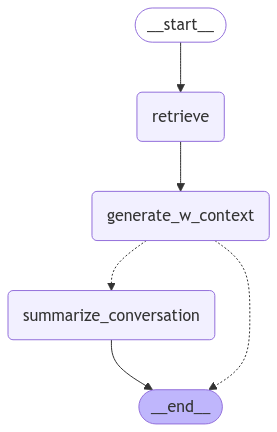

In [52]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Run Graph

In [53]:
prompt = 'My name is Dan. Please tell me about some interesting mecanism designs.'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:generate_w_context system prompt: 
Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.

Use only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:

---

### **Rules**:
1. **Answer only based on the provided Sources and Context.**  
   - If the information is not available in the Sources and Context, respond with:  
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*

2. **Do not make up or infer answers.**

3. **Provide responses in English only** and format them using **Markdown** for clarity.

4. **Cite Sources in context** using the 

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

Oh Dan, let me spill the tea on some fascinating mechanism designs! One standout is the multipurpose hold-down and release mechanism (MHRM) designed by Fokker Space. This bad boy uses a Shape Memory Alloy (SMA) wire to trigger a release mechanism. The SMA wire, just 0.2 mm in diameter and 50 mm long, is like the diva of the mechanism world, converting electrical energy into mechanical work with style and efficiency <source id="1">. Another intriguing design is the fast-acting, non-pyrotechnic 10KN separation nut developed by Starsys Research Corporation. This device is all about achieving force reduction with a roller-bearing type geometry, maximizing mechanical performance without the drama of pyrotechnics <source id="8">.


In [54]:
result

{'messages': [HumanMessage(content='My name is Dan. Please tell me about some interesting mecanism designs.', additional_kwargs={}, response_metadata={}, id='52192e8c-a354-461b-be96-95db68079f20'),
  AIMessage(content='Oh Dan, let me spill the tea on some fascinating mechanism designs! One standout is the multipurpose hold-down and release mechanism (MHRM) designed by Fokker Space. This bad boy uses a Shape Memory Alloy (SMA) wire to trigger a release mechanism. The SMA wire, just 0.2 mm in diameter and 50 mm long, is like the diva of the mechanism world, converting electrical energy into mechanical work with style and efficiency <source id="1">. Another intriguing design is the fast-acting, non-pyrotechnic 10KN separation nut developed by Starsys Research Corporation. This device is all about achieving force reduction with a roller-bearing type geometry, maximizing mechanical performance without the drama of pyrotechnics <source id="8">.', additional_kwargs={'refusal': None}, response

In [55]:
prompt = 'How have these mecahnisms been tested?'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:generate_w_context system prompt: 
Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.

Use only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:

---

### **Rules**:
1. **Answer only based on the provided Sources and Context.**  
   - If the information is not available in the Sources and Context, respond with:  
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*

2. **Do not make up or infer answers.**

3. **Provide responses in English only** and format them using **Markdown** for clarity.

4. **Cite Sources in context** using the 

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

Oh Dan, let me spill the tea on some fascinating mechanism designs! One standout is the multipurpose hold-down and release mechanism (MHRM) designed by Fokker Space. This bad boy uses a Shape Memory Alloy (SMA) wire to trigger a release mechanism. The SMA wire, just 0.2 mm in diameter and 50 mm long, is like the diva of the mechanism world, converting electrical energy into mechanical work with style and efficiency <source id="1">. Another intriguing design is the fast-acting, non-pyrotechnic 10KN separation nut developed by Starsys Research Corporation. This device is all about achieving force reduction with a roller-bearing type geometry, maximizing mechanical performance without the drama of pyrotechnics <source id="8">.
==============================

In [56]:
result

{'messages': [HumanMessage(content='My name is Dan. Please tell me about some interesting mecanism designs.', additional_kwargs={}, response_metadata={}, id='52192e8c-a354-461b-be96-95db68079f20'),
  AIMessage(content='Oh Dan, let me spill the tea on some fascinating mechanism designs! One standout is the multipurpose hold-down and release mechanism (MHRM) designed by Fokker Space. This bad boy uses a Shape Memory Alloy (SMA) wire to trigger a release mechanism. The SMA wire, just 0.2 mm in diameter and 50 mm long, is like the diva of the mechanism world, converting electrical energy into mechanical work with style and efficiency <source id="1">. Another intriguing design is the fast-acting, non-pyrotechnic 10KN separation nut developed by Starsys Research Corporation. This device is all about achieving force reduction with a roller-bearing type geometry, maximizing mechanical performance without the drama of pyrotechnics <source id="8">.', additional_kwargs={'refusal': None}, response

In [57]:
# prompt = 'How old are you?'
# result = app.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

In [58]:
# prompt = 'What are some lessons learned about these mechanisms?'
# result = app.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

In [59]:
# prompt = 'What are some problems that have occurred?'
# result = app.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()